In [25]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
import pandas as pd
import sys
import importlib.util


module_path = "TransformadoresPersonalizados.py"
spec = importlib.util.spec_from_file_location("TransformadoresPersonalizados", module_path)
module = importlib.util.module_from_spec(spec)
sys.modules["TransformadoresPersonalizados"] = module
spec.loader.exec_module(module)

# Ahora puedes importar las clases desde el módulo cargado
from TransformadoresPersonalizados import (
    TildeCorrector,
    TextCleaner
)


df = pd.read_csv("ODScat_345.csv")



# Preprocesador: Aplica TF-IDF a la columna 'Textos_espanol'
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'Textos_espanol')  # Aplica TF-IDF a la columna de texto
    ], remainder='drop'  # Ignorar otras columnas por ahora
)

# Dividir los datos
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["sdg"]), df['sdg'], test_size=0.2, random_state=42)

# Pipeline con preprocesamiento y SVM
pipeline = Pipeline([
    ("tilde_corrector", TildeCorrector(columna="Textos_espanol")),
    ("text_cleaner", TextCleaner(columna="Textos_espanol")),
    ("preprocessor", preprocessor),
    ("svm", SVC(kernel='linear'))
])

# Ajustar el pipeline
pipeline.fit(x_train, y_train)







Exactitud: 0.98


In [26]:
import matplotlib.pyplot as plt
from sklearn.calibration import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


y_train_pred = cross_val_predict(pipeline, x_train, y_train, cv=5)

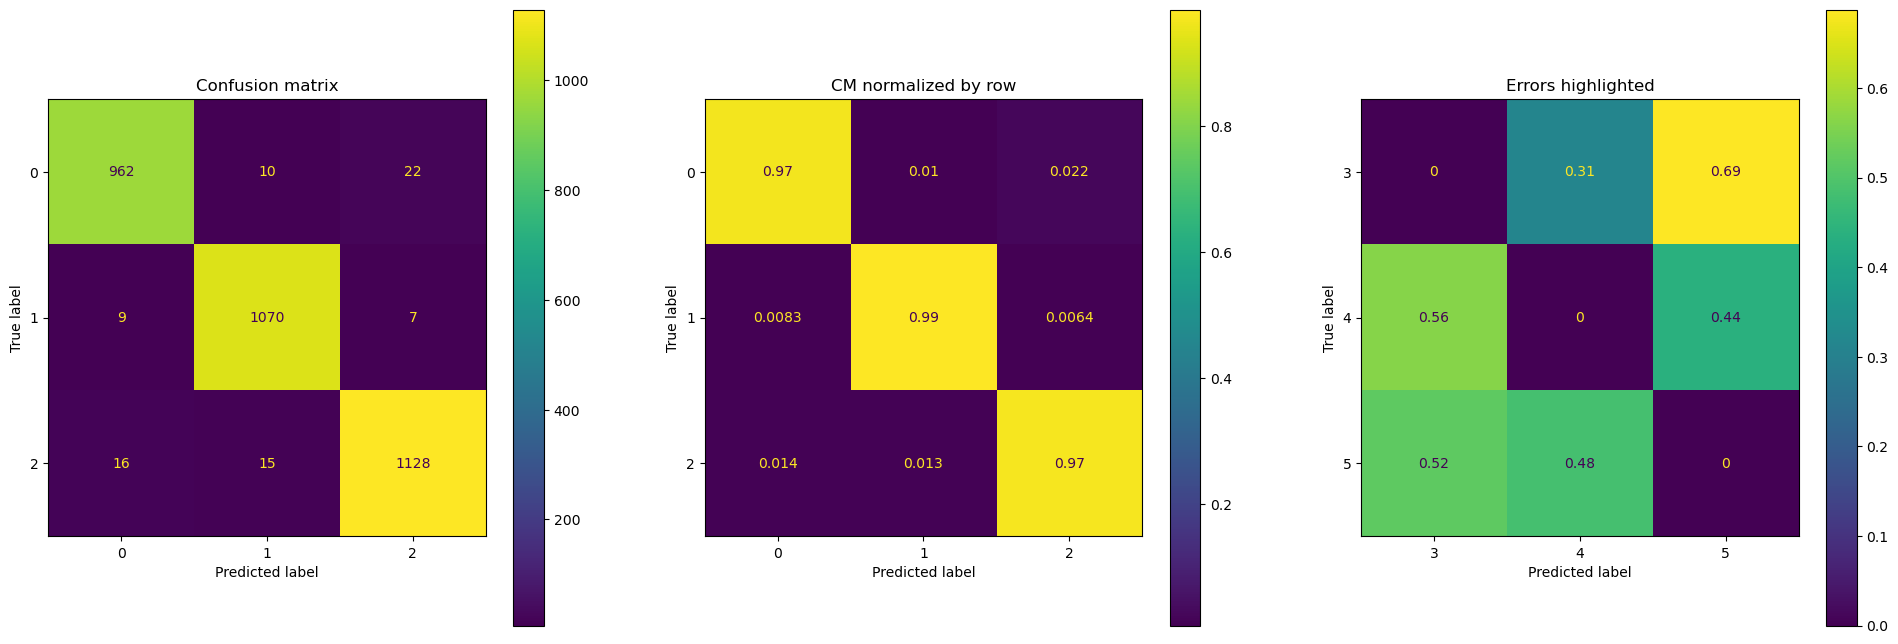

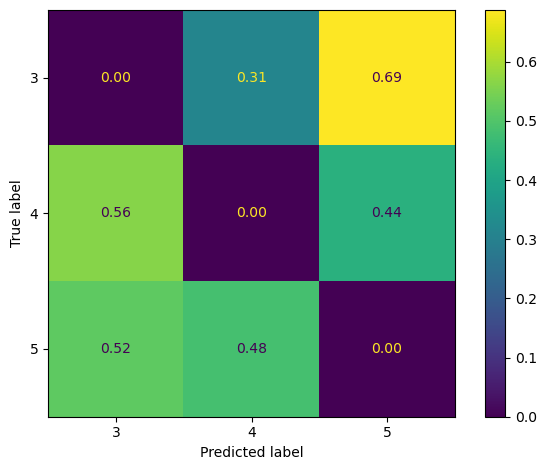

In [27]:
def graficar_matrices_confusion(y, y_pred):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Crear una fila con 3 columnas para los gráficos
    
    # Primera gráfica: Confusion matrix básica
    ConfusionMatrixDisplay(confusion_matrix(y, y_pred)).plot(ax=axes[0], cmap="viridis")
    axes[0].set_title("Confusion matrix")

    # Segunda gráfica: Confusion matrix normalizada
    ConfusionMatrixDisplay(confusion_matrix(y, y_pred, normalize='true')).plot(ax=axes[1], cmap="viridis")
    axes[1].set_title("CM normalized by row")

    # Tercera gráfica: Confusion matrix con los errores resaltados
    sample_weight = (y_pred != y)
    ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true", values_format=".2f", sample_weight=sample_weight).plot(ax=axes[2], cmap="viridis")
    axes[2].set_title("Errors highlighted")

    # Mostrar todas las gráficas
    plt.tight_layout()
    plt.show()


graficar_matrices_confusion(y_train, y_train_pred)

In [28]:
import joblib


joblib.dump(pipeline, 'pipeline_modelo.joblib')

['pipeline_modelo.joblib']

In [30]:
pipeline_cargado = joblib.load('pipeline_modelo.joblib')

df_pruebas = pd.read_csv("TestODScat_345.csv")

y_pred = pipeline_cargado.predict(df_pruebas[["Textos_espanol"]])